<a href="https://colab.research.google.com/github/AbeerProg/RRDS/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install openpyxl

import os, io, re, time, json, zipfile, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D,
                                     Dense, Dropout, Concatenate, LayerNormalization, Reshape,
                                     Rescaling, Softmax, Dot, LSTM, Bidirectional)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Speed/Memory friendly defaults
MAX_VOCAB = 20000
MAX_LEN   = 100
EMB_DIM   = 64
CONV_F    = 64
LSTM_U    = 64
EPOCHS    = 10
BATCH     = 128
PATIENCE  = 2

# Reproducibility
os.environ["PYTHONHASHSEED"] = "42"
tf.keras.utils.set_random_seed(42)
try: tf.config.experimental.enable_op_determinism()
except: pass

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices('GPU'))


TF: 2.19.0 | GPU: []


In [2]:
from google.colab import files
uploaded = files.upload()    # pick your .xlsx
xlsx_name = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[xlsx_name]), sheet_name=0)

# Your declared schema:
expected = ['text','PM Ratio','FPSP Ratio','Review Length','RW Ratio','Sentiment','Generalization',
            'Passive Voice','Total reviewer reviews','Account type','Useful votes','Attached Medias',
            'label','_Account type_code']
print("Columns found:", df.columns.tolist())

# Ensure needed columns exist
need = set(expected)
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Basic cleaning
df['text']  = df['text'].astype(str)
df['label'] = df['label'].apply(lambda v: 1 if str(v).strip().lower() in {"1","true","yes","fake","deceptive","spam"} else 0).astype(int)

# If _Account type_code is all NaN, build it from "Account type"
if df['_Account type_code'].isna().all():
    cats = df['Account type'].astype('string').fillna('unknown')
    cat_map = {cat:i+1 for i,cat in enumerate(sorted(cats.unique()))}
    df['_Account type_code'] = cats.map(cat_map).fillna(0).astype('int32')
else:
    cat_map = {}  # optional

# Auto-fill Review Length if missing
if df['Review Length'].isna().any():
    df['Review Length'] = df['text'].str.split().apply(len)

# Force numerics
num_cols = ['PM Ratio','FPSP Ratio','Review Length','RW Ratio','Sentiment','Generalization','Passive Voice',
            'Total reviewer reviews','Useful votes','Attached Medias','_Account type_code']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype('float32')

print(df.head(3))
print("Class balance:", df['label'].value_counts(normalize=True).round(3).to_dict())


Saving reviews_dataset.xlsx to reviews_dataset.xlsx
Columns found: ['text', 'PM Ratio', 'FPSP Ratio', 'Review Length', 'RW Ratio', 'Sentiment', 'Generalization', 'Passive Voice', 'Total reviewer reviews', 'Account type', 'Useful votes', 'Attached Medias', 'label']


ValueError: Missing columns: ['_Account type_code']

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize
tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(df['text'].str.lower())
seqs = tok.texts_to_sequences(df['text'].str.lower())
X_text = pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')
word_index = tok.word_index

# Cue lexicons (small but useful)
HEDGES = set("maybe perhaps probably possibly generally typically kind sort almost seems appear apparently likely unlikely somehow".split())
INTENS = set("very really absolutely extremely totally completely incredibly highly perfectly utterly definitely certainly terribly unbelievably".split())
SUPERL = set("best worst greatest least most amazing awesome horrible terrible excellent fantastic awful unbelievable".split())
VAGUE  = set("some many few several lots bunch plenty nice good bad stuff things someone somewhere sometime".split())
SENS   = set("taste tasty flavorful sweet salty bitter spicy crunchy soft crispy smell aroma noisy quiet loud texture creamy tender juicy bright dark dim".split())
def ids_for(words): return {word_index[w] for w in words if w in word_index}

HEDGE_IDS, INTENS_IDS, SUPER_IDS, VAGUE_IDS, SENS_IDS = map(ids_for, [HEDGES,INTENS,SUPERL,VAGUE,SENS])

def build_cue_mask(seq):
    return [1.0 if tok in HEDGE_IDS or tok in INTENS_IDS or tok in SUPER_IDS or tok in VAGUE_IDS or tok in SENS_IDS else 0.0
            for tok in seq]

X_mask = np.array([build_cue_mask(s) for s in X_text], dtype='float32')

# Global verifiability features
CURRENCY_RE = re.compile(r'(?:\$|€|£|sar|aed|usd)\s?\d+|\d+\s?(?:sar|aed|usd)', re.I)
TIME_RE     = re.compile(r'\b(?:\d{1,2}:\d{2}\s?(?:am|pm)?|at\s?\d{1,2}(?:am|pm)?)\b', re.I)
DATE_RE     = re.compile(r'\b(?:\d{1,2}[/-]\d{1,2}(?:[/-]\d{2,4})?)\b')
CLICHES     = set(["hidden gem","to die for","out of this world","highly recommend","never again",
                   "best ever","worst ever","one of the best","top notch","would come back"])

def global_features(text:str):
    t=str(text).lower()
    digits   = sum(ch.isdigit() for ch in t)
    currency = 1 if CURRENCY_RE.search(t) else 0
    timehit  = 1 if TIME_RE.search(t) else 0
    datehit  = 1 if DATE_RE.search(t) else 0
    cliches  = sum(1 for ph in CLICHES if ph in t)
    return [digits, currency, timehit, datehit, cliches]

X_global = np.array([global_features(t) for t in df['text']], dtype='float32')

# Metadata matrix (exact 11 numeric columns)
META_COLS = ['PM Ratio','FPSP Ratio','Review Length','RW Ratio','Sentiment','Generalization',
             'Passive Voice','Total reviewer reviews','Useful votes','Attached Medias']
X_meta = df[META_COLS].values.astype('float32')

y = df['label'].values.astype('int32')
y_aux = ((X_global[:,1] + X_global[:,2] + X_global[:,3]) > 0).astype('int32')  # verifiability presence


In [5]:
# Fixed split (saves indices)
if all(os.path.exists(f"/content/{n}.npy") for n in ["idx_tr","idx_va","idx_te"]):
    idx_tr = np.load("/content/idx_tr.npy"); idx_va = np.load("/content/idx_va.npy"); idx_te = np.load("/content/idx_te.npy")
else:
    idx_all = np.arange(len(df))
    idx_tr, idx_te = train_test_split(idx_all, test_size=0.15, random_state=42, stratify=y)
    idx_tr, idx_va = train_test_split(idx_tr, test_size=0.1765, random_state=4242, stratify=y[idx_tr])
    np.save("/content/idx_tr.npy", idx_tr); np.save("/content/idx_va.npy", idx_va); np.save("/content/idx_te.npy", idx_te)

# Slice
X_text_tr, X_text_va, X_text_te = X_text[idx_tr], X_text[idx_va], X_text[idx_te]
X_mask_tr, X_mask_va, X_mask_te = X_mask[idx_tr], X_mask[idx_va], X_mask[idx_te]
X_g_tr,   X_g_va,   X_g_te      = X_global[idx_tr], X_global[idx_va], X_global[idx_te]
X_meta_tr, X_meta_va, X_meta_te = X_meta[idx_tr],   X_meta[idx_va],   X_meta[idx_te]
y_tr, y_va, y_te                = y[idx_tr], y[idx_va], y[idx_te]
yaux_tr, yaux_va, yaux_te       = y_aux[idx_tr], y_aux[idx_va], y_aux[idx_te]

# Standardize metadata using train-only stats
meta_mean = X_meta_tr.mean(axis=0); meta_std = X_meta_tr.std(axis=0) + 1e-6
def norm_meta(x): return (x - meta_mean) / meta_std
X_meta_tr, X_meta_va, X_meta_te = norm_meta(X_meta_tr), norm_meta(X_meta_va), norm_meta(X_meta_te)

print("Shapes:",
      "text", X_text_tr.shape, X_text_va.shape, X_text_te.shape,
      "| meta", X_meta_tr.shape, "| global", X_g_tr.shape)


Shapes: text (17615, 100) (3776, 100) (3775, 100) | meta (17615, 10) | global (17615, 5)


In [6]:
# Fixed split (saves indices)
if all(os.path.exists(f"/content/{n}.npy") for n in ["idx_tr","idx_va","idx_te"]):
    idx_tr = np.load("/content/idx_tr.npy"); idx_va = np.load("/content/idx_va.npy"); idx_te = np.load("/content/idx_te.npy")
else:
    idx_all = np.arange(len(df))
    idx_tr, idx_te = train_test_split(idx_all, test_size=0.15, random_state=42, stratify=y)
    idx_tr, idx_va = train_test_split(idx_tr, test_size=0.1765, random_state=4242, stratify=y[idx_tr])
    np.save("/content/idx_tr.npy", idx_tr); np.save("/content/idx_va.npy", idx_va); np.save("/content/idx_te.npy", idx_te)

# Slice
X_text_tr, X_text_va, X_text_te = X_text[idx_tr], X_text[idx_va], X_text[idx_te]
X_mask_tr, X_mask_va, X_mask_te = X_mask[idx_tr], X_mask[idx_va], X_mask[idx_te]
X_g_tr,   X_g_va,   X_g_te      = X_global[idx_tr], X_global[idx_va], X_global[idx_te]
X_meta_tr, X_meta_va, X_meta_te = X_meta[idx_tr],   X_meta[idx_va],   X_meta[idx_te]
y_tr, y_va, y_te                = y[idx_tr], y[idx_va], y[idx_te]
yaux_tr, yaux_va, yaux_te       = y_aux[idx_tr], y_aux[idx_va], y_aux[idx_te]

# Standardize metadata using train-only stats
meta_mean = X_meta_tr.mean(axis=0); meta_std = X_meta_tr.std(axis=0) + 1e-6
def norm_meta(x): return (x - meta_mean) / meta_std
X_meta_tr, X_meta_va, X_meta_te = norm_meta(X_meta_tr), norm_meta(X_meta_va), norm_meta(X_meta_te)

print("Shapes:",
      "text", X_text_tr.shape, X_text_va.shape, X_text_te.shape,
      "| meta", X_meta_tr.shape, "| global", X_g_tr.shape)


Shapes: text (17615, 100) (3776, 100) (3775, 100) | meta (17615, 10) | global (17615, 5)


In [15]:
def build_cnn_fusion():
    ids  = Input(shape=(MAX_LEN,), dtype='int32', name='text_ids')
    meta = Input(shape=(X_meta_tr.shape[1],), dtype='float32', name='meta')
    glob = Input(shape=(X_g_tr.shape[1],), dtype='float32', name='global_feats')

    x = Embedding(MAX_VOCAB, EMB_DIM)(ids)
    b3 = GlobalMaxPooling1D()(Conv1D(CONV_F,3,activation='relu',padding='same')(x))
    b4 = GlobalMaxPooling1D()(Conv1D(CONV_F,4,activation='relu',padding='same')(x))
    b5 = GlobalMaxPooling1D()(Conv1D(CONV_F,5,activation='relu',padding='same')(x))
    txt = Concatenate()([b3,b4,b5])
    txt = LayerNormalization()(txt); txt = Dropout(0.5)(txt)

    m = Dense(64, activation='relu')(meta); m = Dropout(0.3)(m)
    h = Concatenate()([txt, m, glob])
    h = Dense(128, activation='relu')(h); h = Dropout(0.5)(h)
    out = Dense(1, activation='sigmoid', name='main_out')(h)
    m = Model(inputs={'text_ids':ids,'meta':meta,'global_feats':glob}, outputs=out, name='CNN_FUSION')
    m.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_lstm_fusion():
    ids  = Input(shape=(MAX_LEN,), dtype='int32', name='text_ids')
    meta = Input(shape=(X_meta_tr.shape[1],), dtype='float32', name='meta')
    glob = Input(shape=(X_g_tr.shape[1],), dtype='float32', name='global_feats')

    x = Embedding(MAX_VOCAB, EMB_DIM)(ids)
    x = Bidirectional(LSTM(LSTM_U, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(x)
    txt = LayerNormalization()(x); txt = Dropout(0.5)(txt)

    m = Dense(64, activation='relu')(meta); m = Dropout(0.3)(m)
    h = Concatenate()([txt, m, glob])
    h = Dense(128, activation='relu')(h); h = Dropout(0.5)(h)
    out = Dense(1, activation='sigmoid', name='main_out')(h)
    m = Model(inputs={'text_ids':ids,'meta':meta,'global_feats':glob}, outputs=out, name='LSTM_FUSION')
    m.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_cnnlstm_fusion():
    ids  = Input(shape=(MAX_LEN,), dtype='int32', name='text_ids')
    meta = Input(shape=(X_meta_tr.shape[1],), dtype='float32', name='meta')
    glob = Input(shape=(X_g_tr.shape[1],), dtype='float32', name='global_feats')

    x = Embedding(MAX_VOCAB, EMB_DIM)(ids)
    x = Conv1D(CONV_F, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = LSTM(LSTM_U, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
    txt = LayerNormalization()(x); txt = Dropout(0.5)(txt)

    m = Dense(64, activation='relu')(meta); m = Dropout(0.3)(m)
    h = Concatenate()([txt, m, glob])
    h = Dense(128, activation='relu')(h); h = Dropout(0.5)(h)
    out = Dense(1, activation='sigmoid', name='main_out')(h)
    m = Model(inputs={'text_ids':ids,'meta':meta,'global_feats':glob}, outputs=out, name='CNNLSTM_FUSION')
    m.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m


In [16]:
def _in_names(model):  return [t.name.split(':')[0] for t in model.inputs]
def _out_names(model): return [t.name.split(':')[0] for t in model.outputs]

def _pack_inputs(model, split='train'):
    sel = {'train':0,'val':1,'test':2}[split]
    d = {}
    for n in _in_names(model):
        if n.endswith('text_ids'):    d[n] = [X_text_tr, X_text_va, X_text_te][sel]
        elif n.endswith('cue_mask'):  d[n] = [X_mask_tr, X_mask_va, X_mask_te][sel]
        elif n.endswith('global_feats'): d[n] = [X_g_tr, X_g_va, X_g_te][sel]
        elif n.endswith('meta'):      d[n] = [X_meta_tr, X_meta_va, X_meta_te][sel]
        else: raise ValueError(f"Unknown input: {n}")
    return d

def _pack_targets(model, split='train'):
    outs = _out_names(model)
    y_main_map = {'train':y_tr, 'val':y_va, 'test':y_te}
    if any('aux_out' in o for o in outs):
        y_aux_map = {'train':yaux_tr, 'val':yaux_va, 'test':yaux_te}
        return {'main_out': y_main_map[split], 'aux_out': y_aux_map[split]}
    return y_main_map[split]

def _get_probs(model, inputs):
    out = model.predict(inputs, verbose=0)
    if isinstance(out, dict):         return out['main_out'].ravel()
    if isinstance(out, (list,tuple)): return out[0].ravel()
    return out.ravel()

def sweep_threshold(prob, y, steps=61):
    ts = np.linspace(0.05, 0.95, steps)
    rows=[]
    for t in ts:
        yhat = (prob >= t).astype(int)
        rows.append([t,
                     accuracy_score(y, yhat),
                     precision_score(y, yhat, zero_division=0),
                     recall_score(y, yhat, zero_division=0),
                     f1_score(y, yhat, zero_division=0)])
    return pd.DataFrame(rows, columns=['thr','acc','prec','rec','f1'])

def train_and_eval(build_fn, label, metric_for_thr='f1'):
    print(f"\n▶ Training {label}")
    model = build_fn()
    cb = [
        EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=1, min_lr=1e-5, verbose=1)
    ]
    tr_in, va_in = _pack_inputs(model, 'train'), _pack_inputs(model, 'val')
    tr_y,  va_y  = _pack_targets(model, 'train'), _pack_targets(model, 'val')

    t0 = time.time()
    model.fit(tr_in, tr_y, validation_data=(va_in, va_y),
              epochs=EPOCHS, batch_size=BATCH, callbacks=cb, verbose=1)
    print(f"   Time: {time.time()-t0:.1f}s")

    # Threshold on validation
    val_prob = _get_probs(model, va_in)
    df_thr   = sweep_threshold(val_prob, y_va, steps=61)
    best_thr = float(df_thr.loc[df_thr[metric_for_thr].idxmax(),'thr'])
    print(f"   Best threshold on val ({metric_for_thr}): {best_thr:.2f}")

    # Test
    te_in = _pack_inputs(model, 'test')
    te_prob = _get_probs(model, te_in)
    yhat = (te_prob >= best_thr).astype(int)
    res = dict(label=label, thr=best_thr,
               acc=accuracy_score(y_te, yhat),
               prec=precision_score(y_te, yhat, zero_division=0),
               rec=recall_score(y_te, yhat, zero_division=0),
               f1=f1_score(y_te, yhat, zero_division=0))
    print(f"   Test: acc={res['acc']:.3f} prec={res['prec']:.3f} rec={res['rec']:.3f} f1={res['f1']:.3f}")
    return model, res, df_thr


In [17]:
# --- FIX: make targets match outputs (single vs dual heads) ---

def _in_names(model):  return [t.name.split(':')[0] for t in model.inputs]
def _out_names(model): return list(model.output_names)  # <- use Keras' names directly

def _pack_inputs(model, split='train'):
    sel = {'train':0,'val':1,'test':2}[split]
    d = {}
    for n in _in_names(model):
        if n.endswith('text_ids'):       d[n] = [X_text_tr, X_text_va, X_text_te][sel]
        elif n.endswith('cue_mask'):     d[n] = [X_mask_tr, X_mask_va, X_mask_te][sel]
        elif n.endswith('global_feats'): d[n] = [X_g_tr,   X_g_va,   X_g_te][sel]
        elif n.endswith('meta'):         d[n] = [X_meta_tr, X_meta_va, X_meta_te][sel]
        else: raise ValueError(f"Unknown input: {n}")
    return d

def _pack_targets(model, split='train'):
    outs = _out_names(model)
    y_main_map = {'train':y_tr, 'val':y_va, 'test':y_te}
    if len(outs) == 2 and 'main_out' in outs and 'aux_out' in outs:
        y_aux_map = {'train':yaux_tr, 'val':yaux_va, 'test':yaux_te}
        return {'main_out': y_main_map[split], 'aux_out': y_aux_map[split]}
    else:
        return y_main_map[split]

def _get_probs(model, inputs):
    out = model.predict(inputs, verbose=0)
    # handle dict/list or single tensor uniformly
    if isinstance(out, dict):         return out['main_out'].ravel()
    if isinstance(out, (list,tuple)): return out[0].ravel()
    return out.ravel()

def sweep_threshold(prob, y, steps=61):
    ts = np.linspace(0.05, 0.95, steps)
    rows=[]
    for t in ts:
        yhat = (prob >= t).astype(int)
        rows.append([t,
                     accuracy_score(y, yhat),
                     precision_score(y, yhat, zero_division=0),
                     recall_score(y, yhat, zero_division=0),
                     f1_score(y, yhat, zero_division=0)])
    return pd.DataFrame(rows, columns=['thr','acc','prec','rec','f1'])

def train_and_eval(build_fn, label, metric_for_thr='f1'):
    print(f"\n▶ Training {label}")
    model = build_fn()
    cb = [
        EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=1, min_lr=1e-5, verbose=1)
    ]
    tr_in, va_in = _pack_inputs(model, 'train'), _pack_inputs(model, 'val')
    tr_y,  va_y  = _pack_targets(model, 'train'), _pack_targets(model, 'val')

    t0 = time.time()
    model.fit(tr_in, tr_y, validation_data=(va_in, va_y),
              epochs=EPOCHS, batch_size=BATCH, callbacks=cb, verbose=1)
    print(f"   Time: {time.time()-t0:.1f}s")

    # Threshold on validation for main_out
    val_prob = _get_probs(model, va_in)
    df_thr   = sweep_threshold(val_prob, y_va, steps=61)
    best_thr = float(df_thr.loc[df_thr[metric_for_thr].idxmax(),'thr'])
    print(f"   Best threshold on val ({metric_for_thr}): {best_thr:.2f}")

    # Test
    te_in = _pack_inputs(model, 'test')
    te_prob = _get_probs(model, te_in)
    yhat = (te_prob >= best_thr).astype(int)
    res = dict(label=label, thr=best_thr,
               acc=accuracy_score(y_te, yhat),
               prec=precision_score(y_te, yhat, zero_division=0),
               rec=recall_score(y_te, yhat, zero_division=0),
               f1=f1_score(y_te, yhat, zero_division=0))
    print(f"   Test: acc={res['acc']:.3f} prec={res['prec']:.3f} rec={res['rec']:.3f} f1={res['f1']:.3f}")
    return model, res, df_thr


In [19]:
models = []
results = []
cnn_model, cnn_res, _   = train_and_eval(build_cnn_fusion,   "CNN (fusion)")
lstm_model, lstm_res, _ = train_and_eval(build_lstm_fusion,  "LSTM (fusion)")
cl_model, cl_res, _     = train_and_eval(build_cnnlstm_fusion,"CNN-LSTM (fusion)")

models += [ cnn_model, lstm_model, cl_model]
results+= [ cnn_res,   lstm_res,   cl_res  ]

df_res = pd.DataFrame(results).sort_values('f1', ascending=False).reset_index(drop=True)
print("\n=== Comparison (same splits, validation-thresholded) ===")
df_res



▶ Training CNN (fusion)
Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.6791 - loss: 0.5878 - val_accuracy: 0.8194 - val_loss: 0.3850 - learning_rate: 0.0010
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.8241 - loss: 0.3819 - val_accuracy: 0.8392 - val_loss: 0.3469 - learning_rate: 0.0010
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.8652 - loss: 0.3050 - val_accuracy: 0.8448 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9089 - loss: 0.2275
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
138/138 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - accuracy: 0.9089 - loss: 0.2274 - val_accuracy: 0.8509 - val_loss: 0.3470 - learning_rate: 0.0010
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9373 - loss: 0.1649
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms

,label,thr,acc,prec,rec,f1
0,CNN-LSTM (fusion),0.44,0.862781,0.841737,0.893482,0.866838
1,CNN (fusion),0.29,0.843179,0.801023,0.913090,0.853393
2,LSTM (fusion),0.44,0.838940,0.810890,0.883943,0.845842


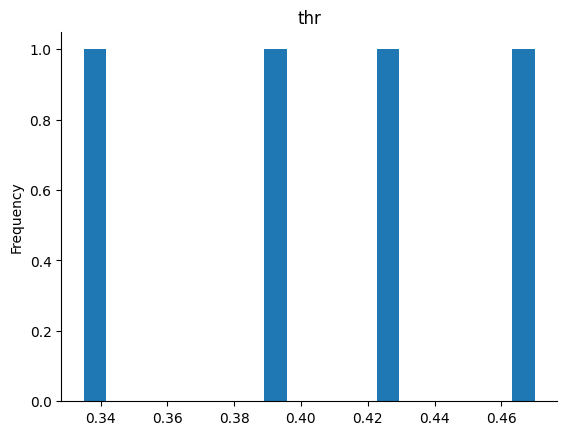

In [14]:
from matplotlib import pyplot as plt
df_res['thr'].plot(kind='hist', bins=20, title='thr')
plt.gca().spines[['top', 'right',]].set_visible(False)

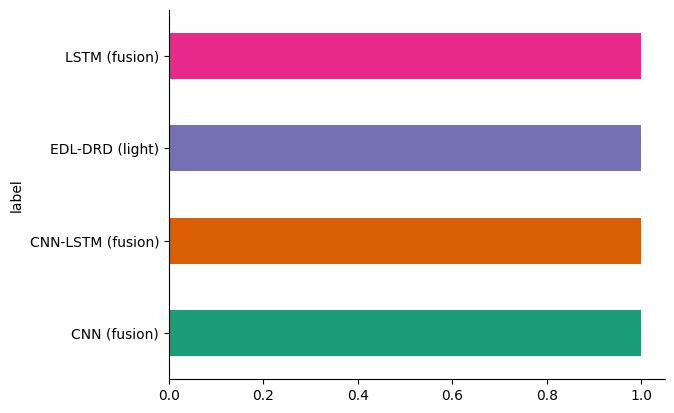

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns
df_res.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Save results CSV
df_res.to_csv("/content/model_comparison.csv", index=False)

# Save EDL-DRD artifacts (optional)
edl_model.save("/content/edl_drd_light.keras")
open("/content/tokenizer.json","w").write(tok.to_json())
np.save("/content/meta_mean.npy", meta_mean)
np.save("/content/meta_std.npy",  meta_std)
open("/content/meta_cols.json","w").write(json.dumps(META_COLS, indent=2))

with zipfile.ZipFile("/content/edl_drd_artifacts.zip","w") as z:
    for p in ["edl_drd_light.keras","tokenizer.json","meta_mean.npy","meta_std.npy","meta_cols.json","model_comparison.csv"]:
        z.write("/content/"+p, arcname=p)

from google.colab import files
files.download("/content/model_comparison.csv")
# files.download("/content/edl_drd_artifacts.zip")   # uncomment to download the zip
